# LangGraph Quick Start

Building a support chatbot in LangGraph
- Answer common question
- Maintain conversation state
- Route comples queries
- Use custom state
- Rewind and explore

## Setup

In [ ]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain_ollama

In [10]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")



## 1. Build a basic chatbot

In [1]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Type of messages: list
    # `add_messages`: how this state key should be updated
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

1. Node
    - INPUT: the current State
    - OUTPUT: a value that updates the state
2. Messages
    - Appended to the existing list
    - Communicated via `add_messages` in `Annotated`

In [2]:
from langchain_ollama import ChatOllama

llm = ChatOllama(model="llama3.1")

def chatbot(state: State):
    return{"messages": [llm.invoke(state["messages"])]}

# 1st arg: unique node name
# 2nd arg: function or object called whenever the node's used
graph_builder.add_node("chatbot", chatbot)

`entry`: Where to start its work

In [3]:
graph_builder.add_edge(START, "chatbot")

`finish`: any time this node is run, you can exit

In [4]:
graph_builder.add_edge("chatbot", END)

`CompiledGraph`: we can use invoke on our state

In [5]:
graph = graph_builder.compile()

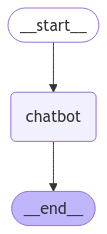

In [6]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # (Optional) extra dependecies
    pass

In [9]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: I don't have specific information on a project or tool named "LangGraph". It's possible that it could be related to:

1. **Language graphs**: In computational linguistics, graph-based representations can model complex relationships between language units (e.g., words, concepts), facilitating tasks like semantic analysis and reasoning.
2. **A programming library or framework**: LangGraph might be a name for a specialized software tool focused on tasks such as parsing natural languages into structured formats, managing linguistic data, or offering utilities for lexical or syntactic analysis.
3. **An academic project or research initiative**: It could represent an ongoing research endeavor in linguistics, computer science, or related fields, focusing on developing new methodologies, models, or tools.

If you are looking for specific details about LangGraph, I recommend searching online for official documentation, articles, presentations, or websites from the creators of the too

## 2. Enhencing the Chatbot with Tools

In [ ]:
%%capture --no-stderr
%pip install -U tavily-python langchain_community

### Requireements

In [2]:
_set_env("TAVILY_API_KEY")

In [12]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://langchain-ai.github.io/langgraph/concepts/low_level/',
  'content': 'Nodes¶ In LangGraph, nodes are typically python functions (sync or async) where the first positional argument is the state, and (optionally), the second positional argument is a "config", containing optional configurable parameters (such as a thread_id). Similar to NetworkX, you add these nodes to a graph using the add_node method:'},
 {'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
  'content': "In LangGraph, each node represents an LLM agent, and the edges are the communication channels between these agents. This structure allows for clear and manageable workflows, where each agent performs specific tasks and passes information to other agents as needed. State management. One of LangGraph's standout features is its automatic state"}]

**The same as in Part 1**

In [13]:
from typing import Annotated

from langchain_ollama import ChatOllama
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatOllama(model="llama3.1")
# Tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

`BasicToolNode`
- Checkts the most recent message in the state and calls tools if the message contains `tool_calls`.
- Relies on the LLM's `tool_calling` support


In [14]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

(Conditional)Edges route the control flow(containing "if")
- `route_tools`: checks for tool_calls in the chatbot's output.
- `add_conditional_edges`: tells the graph that whenever the `chatbot` ndoe completes to check this function.

In [15]:
from typing import Literal


def route_tools(
    state: State,
) -> Literal["tools", "__end__"]:
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"

# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    {"tools": "tools", "__end__": "__end__"},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

**Notice** that conditional edges start from a single node. This tells the graph "any time the `chatbot` node runs, either go to 'tools' if it calls a tool, or end the loop if it responds directly.

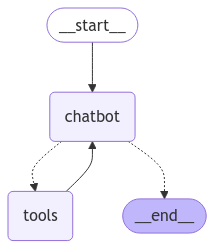

In [16]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [18]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: 
Assistant: [{"url": "https://langchain-ai.github.io/langgraph/", "content": "LangGraph is a framework for creating stateful, multi-actor applications with LLMs, using cycles, controllability, and persistence. Learn how to use LangGraph with LangChain, LangSmith, and Anthropic tools to build agent and multi-agent workflows."}, {"url": "https://www.datacamp.com/tutorial/langgraph-tutorial", "content": "LangGraph is a library within the LangChain ecosystem that simplifies the development of complex, multi-agent large language model (LLM) applications. Learn how to use LangGraph to create stateful, flexible, and scalable systems with nodes, edges, and state management."}]
Assistant: Based on the search results, it appears that LangGraph is a framework for creating stateful, multi-actor applications with Large Language Models (LLMs). It allows developers to build complex systems with features such as cycles, controllability, and persistence. LangGraph is part of the LangChain ec

## 3. Adding memory to the chatbot

**Persistent checkpointing** get out agent to remember the context 

In [22]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In a production app, Change this to use SqliteSaver or PostgresSaver.

In [20]:
from typing import Annotated

from langchain_ollama import ChatOllama
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOllama(model="llama3.1")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the nxt step
graph_builder.add_edge("tools", "chatbot") 
graph_builder.add_edge(START, "chatbot") 

In [23]:
graph = graph_builder.compile(checkpointer=memory)

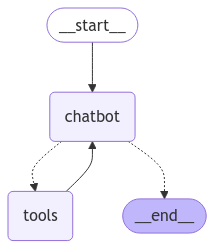

In [24]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # Optional
    pass

In [25]:
config = {"configurable": {"thread_id": "1"}}

In [26]:
user_input = "Hi there! My name is Dustin."

# config: 2nd arg to stream() or invoke()
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Dustin.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (fefcdc6e-ea23-4d61-9347-ef927566e28e)
 Call ID: fefcdc6e-ea23-4d61-9347-ef927566e28e
  Args:
    query: Dustin
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://comicskingdom.com/dustin", "content": "The creative team behind Dustin combines the talents of established political cartoonists Steve Kelley, who writes the strip, and Jeff Parker, who draws it. Kelley has extensive experience producing humor. In 1985, he began writing comedy and performing at open-mike nights in San Diego. His incisive wit and dry delivery quickly propelled him to"}, {"url": "https://comicskingdom.com/dustin/2024-11-24", "content": "Share Bookmark Dustin - 2024-11-16 Buy a Print of this Comic. Fri,

**Note:** The config(**the 2nd positional arguement**) is not nested within the inputs

In [27]:
user_input = "Remember my name?"

# config: 2nd arg to stream() or invoke()
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (539d29f7-ad22-49af-884e-afbed72dc027)
 Call ID: 539d29f7-ad22-49af-884e-afbed72dc027
  Args:
    query: Dustin
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://comicskingdom.com/dustin/2024-11-24", "content": "Share Bookmark Dustin - 2024-11-16 Buy a Print of this Comic. Fri, November 15, 2024. Dustin. Share Bookmark Dustin - 2024-11-15 Buy a Print of this Comic. Load more comics. Want more Dustin? Upgrade to get premium access. Unlock 250,000+ comics, and join in the fun. Upgrade Now. Terms apply. Converts to continuous service subscription."}, {"url": "https://comicskingdom.com/dustin", "content": "Comics by genre Featured Comic Featured Creator Dustin About Dustin The Dustin comic 

**Notice** No external list for memory

In [28]:
# Difference: thread_id, 2
events = graph.stream(
    {"messages": [("user", user_input)]},
    {"configurable": {"thread_id": 2}},
    stream_mode="values",
) 
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (7aff29dc-32f8-4c8d-96fa-20f7b591a4dd)
 Call ID: 7aff29dc-32f8-4c8d-96fa-20f7b591a4dd
  Args:
    query: my name
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.imdb.com/title/tt12940504/", "content": "My Name (TV Series 2021) - IMDb The Quintessential K-Drama List: Most Popular Korean Shows on IMDb Mu-jin's driver who shows off his fighting skills against Hye-jin in the final showdown, is played by veteran Korean martial arts director/action actor Won Jin, who fans of Hong Kong martial arts movies will recognise as super-kicker Sonny Wong from Operation Scorpio (1992). As this series opens school girl Yoon Ji-woo is hassled by the police and bullied by schoolmates because her est

**Notice** Only `thread_id` changed in the config

In [29]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Dustin.', additional_kwargs={}, response_metadata={}, id='18bc3ec0-6d49-488c-b47b-556eefa127e9'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.1', 'created_at': '2024-11-24T08:42:07.965939Z', 'message': {'role': 'assistant', 'content': '', 'tool_calls': [{'function': {'name': 'tavily_search_results_json', 'arguments': {'query': 'Dustin'}}}]}, 'done_reason': 'stop', 'done': True, 'total_duration': 4704087417, 'load_duration': 35399708, 'prompt_eval_count': 194, 'prompt_eval_duration': 3440000000, 'eval_count': 22, 'eval_duration': 1224000000}, id='run-8b0720a4-b5c3-4d8e-81a3-1a5eb4fa8194-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Dustin'}, 'id': 'fefcdc6e-ea23-4d61-9347-ef927566e28e', 'type': 'tool_call'}], usage_metadata={'input_tokens': 194, 'output_tokens': 22, 'total_tokens': 216}), ToolMessage(content='[{"url": "https://comicskingdom.com/du

In [30]:
snapshot.next # The graph ended this turn

()

## 4. Human-in-the-loop

In [31]:
from typing import Annotated

from langchain_ollama import ChatOllama
from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

memory = MemorySaver()


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOllama(model="llama3.1")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

`interrupt_before`: To break the tool node

In [32]:
graph = graph_builder.compile(
    checkpointer=memory,
    # New!
    interrupt_before=["tools"],
    # interrupt_after=["tools"] # if desired                    
)

In [33]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (351e2a2a-5825-41ec-956d-d4aff62a2be9)
 Call ID: 351e2a2a-5825-41ec-956d-d4aff62a2be9
  Args:
    query: LangGraph


In [34]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

Notice that "next": 'tools' 

In [35]:
existing_message = snapshot.values["messages"][-1]
existing_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph'},
  'id': '351e2a2a-5825-41ec-956d-d4aff62a2be9',
  'type': 'tool_call'}]

In [36]:
# `None`: nothing new
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (351e2a2a-5825-41ec-956d-d4aff62a2be9)
 Call ID: 351e2a2a-5825-41ec-956d-d4aff62a2be9
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://langchain-ai.github.io/langgraph/", "content": "LangGraph is a framework for creating stateful, multi-actor applications with LLMs, using cycles, controllability, and persistence. Learn how to use LangGraph with LangChain, LangSmith, and Anthropic tools to build agent and multi-agent workflows."}, {"url": "https://www.datacamp.com/tutorial/langgraph-tutorial", "content": "LangGraph is a library within the LangChain ecosystem that simplifies the development of complex, multi-agent large language model (LLM) applications. Learn how to use LangGraph to create stateful, flexible, and scalable systems with nodes, edges, and sta

## 5. Manually updating the state

The human can `read` and `write`. 

In [37]:
from typing import Annotated

from langchain_ollama import ChatOllama
from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOllama(model="llama3.1")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    # New!
    interrupt_before=["tools"]
    # interrupt_after=["tools"] # if desired
)

user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}
# config: 2nd arg to stream() or invoke()
events = graph.stream({"messages": [("user", user_input)]}, config)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()


In [38]:
snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
existing_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (777c3517-93d1-4c7e-a547-0b33eb8aa876)
 Call ID: 777c3517-93d1-4c7e-a547-0b33eb8aa876
  Args:
    query: LangGraph


Provide the correct response

In [39]:
from langchain_core.messages import AIMessage, ToolMessage

answer = (
    "LangGraph is a library for building stateful, multi-actor applications with LLMs."
)
new_messages = [
    # ToolMessage for LLM API
    ToolMessage(content=answer, tool_call_id=existing_message.tool_calls[0]["id"]),
    # Populating its response
    AIMessage(content=answer)
]

new_messages[-1].pretty_print()
graph.update_state(
    # Which state to update
    config,
    # The messages will be appended to the existing state
    {"messages": new_messages},
)
print("\n\nLast 2 messages;")
print(graph.get_state(config).values["messages"][-2:])


================================== Ai Message ==================================

LangGraph is a library for building stateful, multi-actor applications with LLMs.


Last 2 messages;
[ToolMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='4a357058-e364-49f3-97ab-c5e818a19ccc', tool_call_id='777c3517-93d1-4c7e-a547-0b33eb8aa876'), AIMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', additional_kwargs={}, response_metadata={}, id='6b86db9f-ad1c-4ae4-9769-51071f2a9b36')]


**Notice**: Our new messages are appended to the messages already in the state.

In [41]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

`update_state` were appended

In [42]:
graph.update_state(
    config,
    {"messages": [AIMessage(content="I'm an AI expert!")]},
    # continue processing as if this node just ran
    as_node="chatbot"
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efaa425-8c3c-609a-8003-56e34c13dc5c'}}

**Notice** that the graph continues into the `tools_condition` edge.

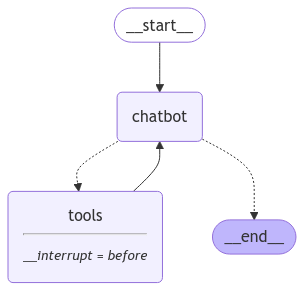

In [43]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # optional
    pass

In [ ]:
snapshot = graph.get_state(config)
print(snapshot.values["messages"][-3:])
print(snapshot.next) # empty

[ToolMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='4a357058-e364-49f3-97ab-c5e818a19ccc', tool_call_id='777c3517-93d1-4c7e-a547-0b33eb8aa876'), AIMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', additional_kwargs={}, response_metadata={}, id='6b86db9f-ad1c-4ae4-9769-51071f2a9b36'), AIMessage(content="I'm an AI expert!", additional_kwargs={}, response_metadata={}, id='dd997e08-1948-409b-92e4-1fea46bbf231')]
()


**Notice** Acting as the `chatbot` and responding with an AIMessages without `toolcalls`

### What if you want to overwrite existing messages?

First, start a new thread.

In [45]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "2"}}  # we'll use thread_id = 2 here
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (d44e7c18-9338-465c-81a9-05f510f5730a)
 Call ID: d44e7c18-9338-465c-81a9-05f510f5730a
  Args:
    query: LangGraph research


Next, update the tool invocation for out agent.

In [46]:
from langchain_core.messages import AIMessage

snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
print("Original")
print("Message ID", existing_message.id)
print(existing_message.tool_calls[0])
new_tool_call = existing_message.tool_calls[0].copy()
new_tool_call["args"]["query"] = "LangGraph human-in-the-loop workflow"
new_message = AIMessage(
    content=existing_message.content,
    tool_calls=[new_tool_call],
    # Important! The ID is how LangGraph knows to REPLACE the message in the state rather than APPEND this messages
    id=existing_message.id,
)

print("Updated")
print(new_message.tool_calls[0])
print("Message ID", new_message.id)
graph.update_state(config, {"messages": [new_message]})

print("\n\nTool calls")
graph.get_state(config).values["messages"][-1].tool_calls

Original
Message ID run-10bd25a4-77fd-4256-a840-1ea54d56e775-0
{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph research'}, 'id': 'd44e7c18-9338-465c-81a9-05f510f5730a', 'type': 'tool_call'}
Updated
{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph human-in-the-loop workflow'}, 'id': 'd44e7c18-9338-465c-81a9-05f510f5730a', 'type': 'tool_call'}
Message ID run-10bd25a4-77fd-4256-a840-1ea54d56e775-0


Tool calls


[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph human-in-the-loop workflow'},
  'id': 'd44e7c18-9338-465c-81a9-05f510f5730a',
  'type': 'tool_call'}]

**Notice** that tool invocation was modified to search for "LangGraph human-in-the-loop workflow" 

In [47]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (d44e7c18-9338-465c-81a9-05f510f5730a)
 Call ID: d44e7c18-9338-465c-81a9-05f510f5730a
  Args:
    query: LangGraph human-in-the-loop workflow
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.youtube.com/watch?v=9BPCV5TYPmg", "content": "In this video, I'll show you how to handle persistence with LangGraph, enabling a unique Human-in-the-Loop workflow. This approach allows a human to grant an"}, {"url": "https://medium.com/@harishreddykondapalli/building-a-human-in-the-loop-movie-recommendation-system-with-langgraph-44541f151e80", "content": "Building a Human-in-the-Loop Movie Recommendation System with LangGraph | by Harish Kondapalli | Nov, 2024 | Medium In this post, I'll walk you through using LangGraph to create a movie recommendation system that allows users to refine their 

**Notice**: the graph queries the search engine using our updated query term

In [48]:
events = graph.stream(
    {
        "messages": (
            "user",
            "Remember what I'm learning about?",
        )
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember what I'm learning about?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (87209724-b3a1-41e5-9af6-f52a0f2dd847)
 Call ID: 87209724-b3a1-41e5-9af6-f52a0f2dd847
  Args:
    query: LangGraph graph-based multi-agent system


The graph **always** interrupted whenever a tool was invoked.

## 6. Customizing State

In [50]:
from typing import Annotated

from langchain_ollama import ChatOllama
from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool



In [51]:
from pydantic import BaseModel

class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str



In [52]:

tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOllama(model="llama3.1")
# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}



In [53]:

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))



In [54]:
from langchain_core.messages import AIMessage, ToolMessage

def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }



In [55]:

graph_builder.add_node("human", human_node)


def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", END: END},
)


In [56]:
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.set_entry_point("chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    # We interrupt before 'human'
    interrupt_before=["human"],
)

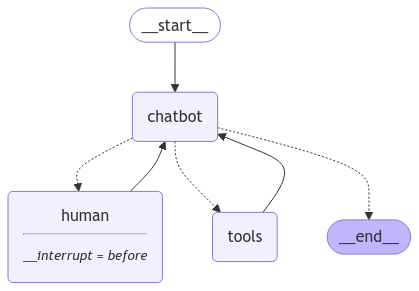

In [57]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [58]:
user_input = "I need some expert guidance for building this AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building this AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  RequestAssistance (783f23ef-d50b-4c14-aa98-3571bd0d132e)
 Call ID: 783f23ef-d50b-4c14-aa98-3571bd0d132e
  Args:
    request: guidance on building an AI agent


**Notice**: the LLM invoked the "`RequestAssistance`" tool, and the interrupt has been set.

In [59]:
snapshot = graph.get_state(config)
snapshot.next

('human',)

Interrupted before the `'human'` node. Next, respond to the chatbot's request by:
1. `ToolMessage`: will be passed back to the `chatbot`.
2. `update_state`: update the graph state.

In [60]:
ai_message = snapshot.values["messages"][-1]
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)
tool_message = create_response(human_response, ai_message)
graph.update_state(config, {"messages": [tool_message]})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efaa445-a0bd-6742-8002-d83ce8bd9bd9'}}

In [61]:
graph.get_state(config).values["messages"]

[HumanMessage(content='I need some expert guidance for building this AI agent. Could you request assistance for me?', additional_kwargs={}, response_metadata={}, id='6b19358e-c5e2-44bc-b904-56b84863e4bd'),
 AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.1', 'created_at': '2024-11-24T09:11:34.207892Z', 'message': {'role': 'assistant', 'content': '', 'tool_calls': [{'function': {'name': 'RequestAssistance', 'arguments': {'request': 'guidance on building an AI agent'}}}]}, 'done_reason': 'stop', 'done': True, 'total_duration': 6277938167, 'load_duration': 571499250, 'prompt_eval_count': 293, 'prompt_eval_duration': 4374000000, 'eval_count': 24, 'eval_duration': 1327000000}, id='run-2a859acd-cd44-47f5-ab42-7f442364b533-0', tool_calls=[{'name': 'RequestAssistance', 'args': {'request': 'guidance on building an AI agent'}, 'id': '783f23ef-d50b-4c14-aa98-3571bd0d132e', 'type': 'tool_call'}], usage_metadata={'input_tokens': 293, 'output_tokens': 24, 'total_token

Next, resume the graph by invoking it with `None`

In [62]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================= Tool Message =================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

Based on the expert's response, I can provide a formatted answer to your original question.

Here is the final answer:

For guidance on building an AI agent, we recommend checking out LangGraph. It's a more reliable and extensible solution compared to simple autonomous agents.


**Notice** that the chatbot incorporated the updated state.

## 7. Time Travel

`get_state_history` rewind the graph by a checkpoint

In [63]:
from typing import Annotated, Literal

from langchain_ollama import ChatOllama
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AIMessage, ToolMessage
# NOTE: you must use langchain-core >= 0.3 with Pydantic v2
from pydantic import BaseModel
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOllama(model="llama3.1")
# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}


graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)


def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", END: END},
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["human"],
)

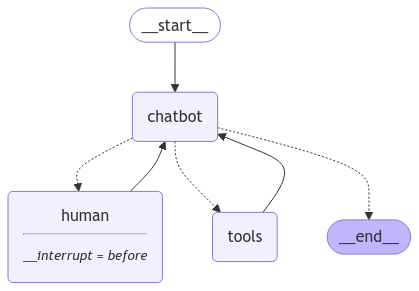

In [64]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [65]:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            ("user", "I'm learning LangGraph. Could you do some research on it for me?")
        ]
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (4b71ec5b-a0f8-4524-b262-cbf52ce489de)
 Call ID: 4b71ec5b-a0f8-4524-b262-cbf52ce489de
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://langchain-ai.github.io/langgraph/", "content": "LangGraph is a framework for creating stateful, multi-actor applications with LLMs, using cycles, controllability, and persistence. Learn how to use LangGraph with LangChain, LangSmith, and Anthropic tools to build agent and multi-agent workflows."}, {"url": "https://www.datacamp.com/tutorial/langgraph-tutorial", "content": "LangGraph is a library within the LangChain ecosystem that simplifies the development of complex, multi-agen

In [66]:
events = graph.stream(
    {
        "messages": [
            ("user", "Ya that's helpful. Maybe I'll build an autonomous agent with it!")
        ]
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (b6bea72a-837b-4cfc-8b4c-c6345582c460)
 Call ID: b6bea72a-837b-4cfc-8b4c-c6345582c460
  Args:
    query: autonomous agent with LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://blog.langchain.dev/how-to-build-the-ultimate-ai-automation-with-multi-agent-collaboration/", "content": "This is the \"master\" agent that coordinates the other agents using LangGraph. This agent acts as the main LangGraph interface. GPT Researcher — A specialized autonomous agent that conducts in depth research on a given topic. Editor — Responsible for planning the research outline and structure."}, {"url": "https://github.com/langchain-ai/langgraph", "co

In [67]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 6:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Messages:  8 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  7 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  6 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  5 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  2 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  1 Next:  ('chatbot',)
-----------------------------------------

**Notice**: checkpoints are saved for every step of the graph, which spans invocations

In [68]:
print(to_replay.next)
print(to_replay.config)

('tools',)
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efaa454-de57-67b0-8006-f91c4b81fa56'}}


**Notice** that checkpoint's config contains a `checkpoint_id` **timestamp**.(LangGraph's checkpointer loads the state from that moment in time)

In [69]:
# The `checkpoint_id` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (b6bea72a-837b-4cfc-8b4c-c6345582c460)
 Call ID: b6bea72a-837b-4cfc-8b4c-c6345582c460
  Args:
    query: autonomous agent with LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://medium.com/@Shrishml/a-primer-on-ai-agents-with-langgraph-understand-all-about-it-0534345190dc", "content": "Hands-on Agents with LangGraph. LangGraph simplifies AI agent development by focusing on three key components: ... Task-driven Autonomous Agent Utilizing GPT-4, Pinecone, and LangChain for Diverse"}, {"url": "https://www.solulab.com/build-ai-agents-with-langgraph/", "content": "AI Development AI Agent Development This blog will provide a detailed guide on How to build AI agents with LangGraph to help you develop your own AI apps. For moving further with the development of AI agents you need to 